# Preparando los datos para los algoritmos de Machine Learning

Este notebook es una adaptación del [original de *Aurélien Gerón*](https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb), de su libro: [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 3rd Edition. Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781098125967/)

## Pasos previos

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

housing = pd.read_csv("./data/housing.csv") 

# Generación de conjuntos de entrenamiento y prueba mediante muestreo estratificado por ingreso medio
train_set, test_set = train_test_split(housing, test_size=0.2,
    stratify=pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])
    )

El **preprocesado** de los datos es una de las tareas más importantes en Machine Learning. Si los datos no están bien preparados, los algoritmos de *Machine Learning* no funcionarán correctamente. Primero vamos a separar los **predictores** de la **variable objetivo** (las **etiquetas**), ya que no necesariamente se aplicarán las mismas **transformaciones** a ambos.

In [2]:
housing = train_set.drop("median_house_value", axis=1) # Eliminamos la columna de la variable dependiente
housing_labels = train_set["median_house_value"].copy() # Guardamos la variable dependiente (etiquetas)

housing.head().T

,11425,10406,1348,10352,8729
longitude,-117.99,-117.59,-121.93,-117.68,-118.32
latitude,33.7,33.66,38.01,33.63,33.85
housing_median_age,25.0,3.0,9.0,13.0,42.0
total_rooms,2017.0,1206.0,2294.0,5830.0,3146.0
total_bedrooms,357.0,256.0,389.0,921.0,770.0
population,1063.0,563.0,1142.0,2897.0,1859.0
households,369.0,287.0,365.0,891.0,740.0
median_income,4.0345,5.1589,5.3363,6.2403,3.5073
ocean_proximity,<1H OCEAN,<1H OCEAN,INLAND,<1H OCEAN,<1H OCEAN


## Tipos de estimadores en scikit-learn


Es importante aclarar ciertos términos que se utilizan en scikit-learn:

- **Estimadores**: cualquier objeto que pueda estimar algunos parámetros basados en un conjunto de datos se llama estimador. La estimación en sí misma se realiza mediante el método **`fit()`**.

    - **Transformadores**: estimadores que además pueden transformar datos usando el método **`transform()`**. Por ejemplo, `SimpleImputer` es un transformador: estima valores con `fit()` y los imputa con `transform()`.
        - Scalers: son transformadores que escalan los datos.
        - Imputers: son transformadores que imputan valores faltantes.
        - Encoders: son transformadores que codifican variables categóricas.
        - Reductores de dimensionalidad: son transformadores que reducen la cantidad de variables.
        - ...

    - **Predictores**: aquellos estimadores que son capaces de hacer predicciones basadas en un conjunto de datos. Por ejemplo, el modelo de regresión lineal es un predictor: estima los hiperparámetros `fit()` y hace predicciones con **`predict()`**. 
        - Clasificadores: son predictores que predicen etiquetas categóricas.
        - Regresores: son predictores que predicen valores continuos.
        - Clusters: son predictores que predicen a qué cluster pertenece un dato.
        - ...

El término "predictor" puede prestarse a confusión ya que también se utiliza, en general, para referirse a las *features* o variables independientes de un modelo, y a veces solo para aquellas variables que son de hecho **predictoras**, dejando fuera aquellas característcas que no tienen capacidad predictiva.

<!-- TODO: Explicar por separado los principios de diseño de scikit-learn en detalle con ejemplos (es un buen modo de trabajar conceptos de ingeniería del software en python)-->

## Valores numéricos no disponibles (*missing values*)
<!-- TODO: categóricos no disponibles >

### Identificación de valores no disponibles

Como vimos al principio, la columna 'total_bedrooms' tiene valores no diponibles. Normalente se hablará como sinónimos de valores no disponibles, ***missing values***, *nulos* o ***na* (not available)**, aunque hay que tener cuidado de cómo se recogieron esos valores, ya que si hay dos tipos de valores (null y *string* vacío, por ejemplo) podría haber información implícita.
<!-- TODO: Revisar distinción entre na, null, missing, datos impuros.... -->

In [3]:
housing.isna().sum() # el método isnull() es un alias de isna()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        163
population              0
households              0
median_income           0
ocean_proximity         0
dtype: int64

In [4]:
null_rows_idx = housing.isnull().any(axis=1) # índices de las filas con valores nulos
housing.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
7806,-118.09,33.89,42.0,991.0,NaN,717.0,219.0,4.0926,<1H OCEAN
7097,-117.98,33.92,27.0,3700.0,NaN,1793.0,552.0,5.3668,<1H OCEAN
5990,-117.73,34.10,37.0,3457.0,NaN,1344.0,530.0,5.8891,INLAND
13311,-117.61,34.08,12.0,4427.0,NaN,2400.0,843.0,4.7147,INLAND
14970,-117.01,32.74,31.0,3473.0,NaN,2098.0,677.0,2.6973,<1H OCEAN


### Eliminación de las filas con valores nulos (***Listwise deletion***)

Podemos simplemente eliminar aquellas instancias incompletas, aunque es problemático porque estamos eliminando información. Especialmente si hay muchos predictores (ya que para solventar el problema de ciertos nulos estamos perdiendo la información de las demás columas).

In [5]:
housing_option1 = housing.dropna(subset=["total_bedrooms"]) 
housing_option1.loc[null_rows_idx].head() # comprobamos que se han eliminado las filas con valores nulos

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


También podríamos directamente eliminar toda fila que tenga un valor na en cualquier columna:

In [6]:
housing_option1b = housing.dropna(axis=0) # eliminamos las filas con valores nulos
housing_option1b.loc[null_rows_idx].head() # comprobamos que se han eliminado las filas con valores nulos 

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


### Eliminación de la columna entera

Eliminar la columna entera es una opción si no es una variable importante, pero en este caso parece que sí lo es dado que, aunque esa *feature* no es la que más correlaciona directamente con la variable objetivo, es una de las dos con las que se calcula `bedrooms_ratio`, que sí es la segunda más correlacionada.

In [7]:
housing_option2 = housing.drop(columns="total_bedrooms")
housing_option2.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
7806,-118.09,33.89,42.0,991.0,717.0,219.0,4.0926,<1H OCEAN
7097,-117.98,33.92,27.0,3700.0,1793.0,552.0,5.3668,<1H OCEAN
5990,-117.73,34.10,37.0,3457.0,1344.0,530.0,5.8891,INLAND
13311,-117.61,34.08,12.0,4427.0,2400.0,843.0,4.7147,INLAND
14970,-117.01,32.74,31.0,3473.0,2098.0,677.0,2.6973,<1H OCEAN


Las filas siguen ahí en este caso porque los índices con nulos se buscaron antes. Si buscamos nulos ahora en housing_option2, no los encontraremos.

In [8]:
housing_option2.isnull().any(axis=None) # comprobamos que no hay valores nulos en el dataset

False

También podríamos eliminar directamente todas las columnas con nulos:

In [9]:
housing.dropna(axis=1).isnull().any(axis=None)

False

### Imputación de algún valor (la mediana en este caso)

La **imputación** de un determinado valor (como cero, la media o la mediana) a esos campos no disponibles es una opción si creemos que los valores no disponibles no responden a ninguna causa concreta, y no sesgan la distribución de la variable<!-- TODO: Revisar Different types of missing data (MCAR, MAR, MNAR) -->.

La imputación de la media (***mean***) es más sensible a los **valores atípicos**, ya que un valor extremo puede afectar mucho a la media. La mediana (***median***) es más robusta a los valores extremos. La moda (***mode***) es el valor que más se repite, y es útil para variables categóricas, pero no tanto para variables continuas.

In [10]:
median = housing["total_bedrooms"].median()
housing_option3 = housing["total_bedrooms"].fillna(median)
housing_option3.loc[null_rows_idx].head()

7806     434.0
7097     434.0
5990     434.0
13311    434.0
14970    434.0
Name: total_bedrooms, dtype: float64

Ahora todas estas filas tienen en total_bedrooms el valor mediano de total_bedrooms.

La clase `SimpleImputer` de scikit-learn nos permite hacer esto de forma más sencilla. Creamos una instancia de `SimpleImputer` indicando que queremos imputar los valores nulos con la mediana, y luego usamos el método `fit()` para calcular la mediana de cada columna y el método `transform()` para aplicar la imputación a todas las columnas.

Vamos a ver cómo se aplicaría este método a todos los campos numéricos del dataframe (recordemos que 'ocean_proximity' es categorial -valores de texto-, y no se puede calcular la mediana de un texto).

In [11]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [12]:
housing_num = housing.select_dtypes(include=[np.number]) # seleccionamos las columnas numéricas

In [13]:
imputer.fit(housing_num) # calculamos la mediana de cada columna numérica
imputer.statistics_ # mediana de cada columna numérica

array([-118.5   ,   34.26  ,   29.    , 2123.5   ,  434.    , 1164.    ,
        409.    ,    3.5333])

Podemos comprobar que los valores son los mismos que calcula el método `median()` del dataframe.

In [14]:
housing_num.median().values

array([-118.5   ,   34.26  ,   29.    , 2123.5   ,  434.    , 1164.    ,
        409.    ,    3.5333])

In [15]:
housing_num_array_tr = imputer.transform(housing_num) # reemplazamos los valores nulos por la mediana

`transform()` devuelve un array de NumPy, pero podríamos convertirlo de nuevo a un DataFrame de Pandas.

In [16]:
housing_tr = pd.DataFrame(housing_num_array_tr, columns=housing_num.columns, index=housing_num.index)
housing_tr.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
7806,-118.09,33.89,42.0,991.0,434.0,717.0,219.0,4.0926
7097,-117.98,33.92,27.0,3700.0,434.0,1793.0,552.0,5.3668
5990,-117.73,34.10,37.0,3457.0,434.0,1344.0,530.0,5.8891
13311,-117.61,34.08,12.0,4427.0,434.0,2400.0,843.0,4.7147
14970,-117.01,32.74,31.0,3473.0,434.0,2098.0,677.0,2.6973


También se podría utilizar directamente el método `fit_transform()` de `SimpleImputer` para calcular el valor a imputar (con `fit()`) y aplicarla (con `transform()`) en un solo paso.

### Modelos de predicción


Existen métodos más avanzados como el uso de **módelos de predicción** (tratando la columna con valores nulos como la variable objetivo y el resto de columnas como *features*). Por ejemplo, podría utilizarse el algoritmo **K-Nearest Neighbors (KNN)** para predecir los valores nulos de 'total_bedrooms' basándonos en los registros sí etiquetados.

## Tratamiento de *features* categóricas

Hemos dejado de lado la columna 'ocean_proximity' porque es una variable categórica. La mayoría de los algoritmos de *Machine Learning* prefieren trabajar con números, por lo que es mejor convertir estas categorías de texto a números. Esto se llama **codificación**(***encoding***).

### OrdinalEncoder

In [17]:
from sklearn.preprocessing import OrdinalEncoder
cat_encoder = OrdinalEncoder()
housing_cat_encoded = cat_encoder.fit_transform(housing[["ocean_proximity"]])
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [18]:
housing_cat_encoded[0,0]

0.0

`OrdinalEncoder` codifica las categorías como números **con un orden**. Esto hará que los algoritmos de *Machine Learning* asuman que dos valores cercanos son más similares que dos valores lejanos. Por ejemplo, si asignamos a 'NEAR BAY' el valor 1, y a 'INLAND' el valor 4, los algoritmos asumirían que 'NEAR BAY' es más similar a 'NEAR OCEAN' (valor 2) que a 'INLAND', lo cual no es cierto.

Si sabemos que las categorías tienen un orden, podemos usar una codificación **ordinal**  (por ejemplo, para categorías ordenadas como "malo", "promedio", "bueno" y "excelente"). En este caso, la cercanía a la costa parece tener un orden. Podríamos hacer una comprobación gráfica representando las categorías sobre un mapa de California, y ver si hay alguna relación entre la categoría y la cercanía a la costa.
<!-- TODO: diferencia con LabelEncoder -->

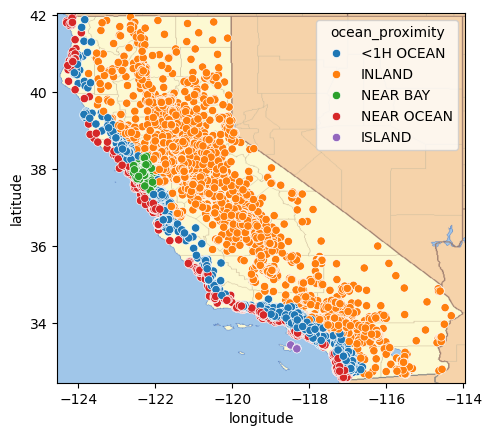

In [19]:
import seaborn as sns
import PIL
import matplotlib.pyplot as plt

sns.scatterplot(x="longitude", y="latitude", hue="ocean_proximity", data=housing)
axis = -124.55, -113.95, 32.45, 42.05 # límites de longitud y latitud de la imagen
plt.imshow(PIL.Image.open("./data/california.png", mode='r'), extent=axis)
plt.show()

Si bien hay cierta relación entre la categoría y la cercanía a la costa, no está claro cómo se relacionan las categorías `INLAND` y `NEAR BAY` con el resto. Por lo tanto, es mejor usar una codificación **no ordinal**.

### OneHotEncoder


Otra solución común cuando no tenemos claro el orden de las categorías es crear un atributo binario por categoría (convertir esa columna en tantas columnas como valores): un atributo igual a 1 cuando la categoría es "<1H OCEAN" (y 0 en caso contrario), otro atributo igual a 1 cuando la categoría es "INLAND" (y 0 en caso contrario), y así sucesivamente. Esto se llama ***one-hot encoding***, porque solo un atributo será igual a 1 (caliente), mientras que los demás serán 0 (fríos). Los nuevos atributos a veces se llaman atributos **dummy**. scikit-learn proporciona la clase `OneHotEncoder` para convertir valores categóricos en vectores *one-hot*.

In [20]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing[["ocean_proximity"]])
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Este método devuelve un ***sparse array*** de **SciPy**, que es una estructura que comprime los arrays de NumPy para ahorrar memoria cuando la mayoría de sus posiciones contienen ceros, almacenando solo los valores distintos de cero con sus posiciones. Si queremos convertirlo a un array de NumPy, podemos usar el método `toarray()`.

In [21]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

También se puede utilizar el argumento `sparse_output=False` en el constructor de `OneHotEncoder`.

In [22]:
OneHotEncoder(sparse_output=False).fit_transform(housing[["ocean_proximity"]])

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

Por su parte, la función `get_dummies()` de pandas hace lo mismo (pero devolviendo un DataFrame de Pandas).

In [23]:
pd.get_dummies(housing["ocean_proximity"]).head()

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
11425,True,False,False,False,False
10406,True,False,False,False,False
1348,False,True,False,False,False
10352,True,False,False,False,False
8729,True,False,False,False,False


Sin embargo, OneHotEncoder, al poder separar el proceso de entrenamiento (con `fit()`) y el de transformación (con `transform()`), recuerda las categorías con las que ha sido entrenado.

Esto no ocurre con `get_dummies()`: si se utiliza en un conjunto de datos de test en el que no aparece una categoría que sí aparecía en el conjunto de entrenamiento, no creará la columna correspondiente, y el conjunto de datos de test y el de entrenamiento tendrán un número distinto de columnas.

In [24]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test) # siempre mapea las categorías existentes en el momento en que se llama

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


In [25]:
cat_encoder.transform(df_test).toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

Podemos ver como OneHotEncoder mantiene las categorías con las que ha sido entrenado, aunque haya categorías sin ningún registro.

Además, si en el conjunto de test aparece una categoría que no ha visto antes, lanzará una excepción. Esto es útil para detectar problemas en el conjunto de test, pero si queremos que simplemente ignore las categorías desconocidas, podemos usar el argumento `handle_unknown='ignore'` en el constructor de `OneHotEncoder`.

In [26]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


In [27]:
# cat_encoder.handle_unknown = "ignore" # así evitamos la excepción y simplemente devuelve ceros
try:
    cat_encoder.transform(df_test_unknown).toarray()
except Exception as e:
    print("EXCEPTION:", str(e))

EXCEPTION: Found unknown categories ['<2H OCEAN'] in column 0 during transform


La información de cómo ha sido entrenado un transformador se almacena en sus atributos. Con el método `get_feature_names_out()` podemos obtener los nombres de las columnas de salida.

In [28]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [29]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [30]:
cat_encoder.handle_unknown = "ignore"
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown).toarray(),
                         columns=cat_encoder.get_feature_names_out(),
                         index=df_test_unknown.index)
df_output 

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


Hay que tener en consideración que si un atributo categorial tiene muchas categorías, el número de columnas puede crecer mucho, lo que puede ralentizar el entrenamiento y hacer que el modelo sea más difícil de entrenar. Además, si una categoría tiene muy pocos ejemplos, es posible que no sea útil.

## Normalización y escalado de *features*

La mayoría de los algoritmos de *Machine Learning* no funcionan bien cuando las *features* tienen escalas muy diferentes. Por ejemplo, muchos **clasificadores** calculan la distancia entre dos puntos mediante la distancia euclidiana. Si una de las características tiene valores mucho más grandes que las demás, la distancia se verá dominada por esta característica. Por ejemplo, en nuestro *dataset*, el rango de 'median_income' va de 0 a 15, mientras que el rango de 'total_rooms' va de 6 a 39.320.

Para evitarlo, es habitual normalizar o estandarizar las *features*.

<!-- TODO: https://en.wikipedia.org/wiki/Normalization_(statistics) -->

In [31]:
housing.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,16512.0,-119.569982,2.001593,-124.3000,-121.8000,-118.5000,-118.01,-114.3100
latitude,16512.0,35.634087,2.135165,32.5500,33.9400,34.2600,37.72,41.9500
housing_median_age,16512.0,28.625666,12.583518,1.0000,18.0000,29.0000,37.00,52.0000
total_rooms,16512.0,2622.766352,2158.770763,2.0000,1439.0000,2123.5000,3150.00,39320.0000
total_bedrooms,16349.0,535.478500,415.835104,2.0000,295.0000,434.0000,647.00,6445.0000
population,16512.0,1417.193314,1100.125199,3.0000,784.0000,1164.0000,1721.00,28566.0000
households,16512.0,497.511991,377.669287,2.0000,278.0000,409.0000,606.00,6082.0000
median_income,16512.0,3.871120,1.900580,0.4999,2.5643,3.5333,4.75,15.0001


### MinMaxScaler

La normalización más común es la **normalización min-max** o ***min-max scaling***. La **normalización min-max** es la más sencilla: los valores se escalan y desplazan de forma que terminen en el rango entre un valor mínimo y un valor máximo. Normalmente será entre 0 y 1, aunque pueden ser otros (las redes neuronales suelen funcionar mejor con *inputs* con media 0 y desviación estándar 1, por lo que a veces se usa el rango -1 a 1). Scikit-Learn proporciona una clase `MinMaxScaler` para esto.

$$ X_{norm} = \frac{X - X_{min}}{X_{max} - X_{min}} $$

In [32]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

### StandardScaler

Por su parte, la **estandarización Z-score** (***standard score***) es diferente: primero resta la media (para que ésta sea 0), y luego divide por la **desviación estándar** para que la distribución resultante tenga desviación estándar 1. A diferencia del escalado min-max, la estandarización no limita los valores entre un rango concreto, pero esto tiene también la ventaja de ser mucho menos sensible a los valores atípicos. Scikit-Learn proporciona una clase `StandardScaler` para esto.

$$ X_{std} = \frac{X - \mu}{\sigma} $$

In [33]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

Las variables objetivo también pueden necesitar ser normalizadas. Por ejemplo podrímos aplicar de nuevo StandardScarler a las etiquetas:


In [34]:
print(type(housing_labels)) # Al ser una única columna, antes almacenamos las etiquetas en un objeto Series
target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame()) # convertimos el target a un dataframe (fit_transform espera 2D)

<class 'pandas.core.series.Series'>


### Normalización de variables objetivo y posterior inversión (ejemplo de regresión lineal simple)

Si transformamos de cualquier manera la variable objetivo, la salida de nuestro modelo también devolverá predicciones transformadas. Si queremos que las predicciones estén en la escala original, necesitaremos invertir la transformación. Muchos de los transformadores de Scikit-Learn tienen un método `inverse_transform()`, lo que facilita calcular la inversa de sus transformaciones.
<!-- TODO: Los transformadores categóricos no lo tienen ya que entonces estaríamos en un problema de clasificación. // No todos son invertibles? -->

Por ejemplo, vamos a entrenar una **regresión lineal simple con el predictor que más correla** (median_income) y las etiquetas que acabamos de escalar. Seguidamente vamos a probar sus predicciones con el conjunto de test y deshacer la transformación.

In [35]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels) # entrenamos el modelo con las variables independientes escalada

some_new_data = housing[["median_income"]].iloc[:5]  # usamos estas filas como si fueran datos nuevos para predecir (no hemos preprocesado el cojunto de test)
# TODO: es necesario preprocesar el conjunto de test?

scaled_predictions = model.predict(some_new_data)
target_scaler.inverse_transform(scaled_predictions) # Deshacemos la transformación para obtener las predicciones en la escala original

array([[213667.0068    ],
       [260642.03751187],
       [268053.43065335],
       [305820.62005528],
       [191641.71669746]])

Este proceso se puede simplificar utilizando la clase `TransformedTargetRegressor` de Scikit-Learn, que permite entrenar un modelo con las etiquetas transformadas y deshacer la transformación automáticamente.    

In [36]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(regressor = LinearRegression(),
                                   transformer = StandardScaler()) # transformador de la variable dependiente
model.fit(housing[["median_income"]], housing_labels)
model.predict(some_new_data)

array([213667.0068    , 260642.03751187, 268053.43065335, 305820.62005528,
       191641.71669746])

<!-- TODO: Custom Transformers (en repo2 planteado como OOP, en repo3 usando FunctionTransformer para volver logarítmico). La comparación es interesante. Ed3 tiene un trasnformer para k-means y RBF -->

## *Pipelines*

Un ***pipeline*** es una secuencia de componentes de procesado de datos. La clase 'Pipeline' de scikit-learn permite encadenar varias secuencias de transformaciones. Todos los **estimadores** excepto el último deben ser **transformadores**. Cuando llamamos al método `fit` de la clase 'Pipeline', se llama al método `fit_transform` de cada estimador secuencialmente, pasando la salida del método `transform` de un estimador al siguiente. El último estimador puede ser de cualquier tipo (transformador, clasificador, regresor, etc.).
<!-- TODO: clarificar tipos de estimadores -->

Vamos a construir un *pipeline* que prepreprocese los predictores numéricos.

El constructor de la clase 'Pipeline' recibe una lista de tuplas formadas por el nombre que identifica a cada estimador y ese estimador. Todos los estimadoes han de ser **transformadores**, excepto el último, que puede ser cualquier tipo de estimador.

In [37]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")), # imputamos la mediana a los valores no disponibles
    ("standardize", StandardScaler()), # estandarizamos los valores
])
num_pipeline.steps

[('impute', SimpleImputer(strategy='median')),
 ('standardize', StandardScaler())]

También se puede usar la función ``make_pipeline``, que crea un *pipeline* como el anterior pero dando un nombre automáticamente a cada estimador.

In [38]:
from sklearn.pipeline import make_pipeline
num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
num_pipeline.steps

[('simpleimputer', SimpleImputer(strategy='median')),
 ('standardscaler', StandardScaler())]

El método `fit()` del *pipeline* llama al método `fit_transform()` de cada transformador, pasando la salida de cada uno al siguiente, y finalmente llama al método `fit()` del último estimador.
El método `fit_transform()` del *pipeline* hace lo mismo, pero llama al método `fit_transform()` del último estimador.


In [39]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[ 0.79, -0.91, -0.29, -0.28, -0.43, -0.32, -0.34,  0.09],
       [ 0.99, -0.92, -2.04, -0.66, -0.67, -0.78, -0.56,  0.68]])

Para visualizar mejor lo que hace el *pipeline*, podemos volver a construir un dataframe con sus resultados.

In [40]:
pd.DataFrame(housing_num_prepared,
            columns=num_pipeline.get_feature_names_out(), # obtenemos nombres de columnas tras transformar
            index=housing_num.index).head(2) 

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
11425,0.789386,-0.905853,-0.288137,-0.280616,-0.428805,-0.321967,-0.340287,0.085966
10406,0.989233,-0.924587,-2.036508,-0.656304,-0.672834,-0.776475,-0.557415,0.677593


In [41]:
num_pipeline[1]

StandardScaler()

In [42]:
num_pipeline[:-1]

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median'))])

In [43]:
num_pipeline.named_steps["simpleimputer"]

SimpleImputer(strategy='median')

In [44]:
num_pipeline.set_params(simpleimputer__strategy="median")

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

Para poder crear un *pipeline* que preprocese además de los predictores numéricos, los categóricos, necesitamos un transformador que seleccione las columnas que queremos transformar. Scikit-learn proporciona la clase `ColumnTransformer` para esto.

In [45]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"), # imputamos la moda a los valores no disponibles
    OneHotEncoder(handle_unknown="ignore")) # codificamos las categorías

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs), # aplicamos el pipeline numérico a las columnas numéricas
    ("cat", cat_pipeline, cat_attribs)], # aplicamos el pipeline categórico a las columnas categóricas
    remainder="passthrough" # el resto de columnas se mantienen sin cambios
)

El parámetro `remainder='passthrough'` indica que las columnas que no se han seleccionado para transformar se pasarán directamente al *pipeline* final sin cambios. Si no se especifica, las columnas que no se han seleccionado se eliminarán (por defecto, `remainder='drop'`). En este caso, se están pasando todas, así que no habrá diferencia.

Para poder asignar pipelines a todas las columnas en función de su tipo, podemos usar la función `make_column_transformer`.

In [46]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

y podemos usar el método `fit_transform()` del *pipeline* para transformar los datos de entrenamiento.

In [47]:
housing_prepared = preprocessing.fit_transform(housing)

In [48]:
housing_prepared_fr = pd.DataFrame(
    housing_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=housing.index)
housing_prepared_fr.head(7).T

,11425,10406,1348,10352,8729,13063,11055
pipeline-1__longitude,0.789386,0.989233,-1.179106,0.944267,0.624512,-0.879335,0.859333
pipeline-1__latitude,-0.905853,-0.924587,1.112787,-0.938638,-0.835598,1.370387,-0.873067
pipeline-1__housing_median_age,-0.288137,-2.036508,-1.559680,-1.241794,1.062878,-0.923908,-1.003380
pipeline-1__total_rooms,-0.280616,-0.656304,-0.152298,1.485721,0.242383,0.456400,-0.202328
pipeline-1__total_bedrooms,-0.428805,-0.672834,-0.351489,0.933887,0.569053,0.356434,-0.056723
pipeline-1__population,-0.321967,-0.776475,-0.250155,1.345166,0.401609,0.251621,-0.462864
pipeline-1__households,-0.340287,-0.557415,-0.350878,1.041917,0.642084,0.446139,-0.083441
pipeline-1__median_income,0.085966,0.677593,0.770935,1.246594,-0.191431,-0.294719,0.370361
pipeline-2__ocean_proximity_<1H OCEAN,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000
pipeline-2__ocean_proximity_INLAND,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000


In [49]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 13)

In [50]:
preprocessing.get_feature_names_out()

array(['pipeline-1__longitude', 'pipeline-1__latitude',
       'pipeline-1__housing_median_age', 'pipeline-1__total_rooms',
       'pipeline-1__total_bedrooms', 'pipeline-1__population',
       'pipeline-1__households', 'pipeline-1__median_income',
       'pipeline-2__ocean_proximity_<1H OCEAN',
       'pipeline-2__ocean_proximity_INLAND',
       'pipeline-2__ocean_proximity_ISLAND',
       'pipeline-2__ocean_proximity_NEAR BAY',
       'pipeline-2__ocean_proximity_NEAR OCEAN'], dtype=object)